In [1]:
%reload_ext autoreload
%autoreload 2
# Import packages and set working directory if needed here
import datetime
import glob
import os

import tempfile

import earthpy.spatial as es
import geopandas as gpds
from matplotlib import pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
from pyproj import Proj, transform
from rasterio import mask
from rasterio.transform import from_origin
import rasterio as rio
import rasterio.plot
import rasterstats as rs

import common_functions as common

landsat_file_root = os.path.join(common.original_raster_data, 'landsat_summer')
landsat_inventory = {'landsat_7':
                        {'2016': [],
                         '2017': []},
                    'landsat_8': 
                        {'2016': ['LC080380322016060101T1-SC20181113111333',
                                 'LC080380322016061701T1-SC20181113111409',
                                 'LC080380322016070301T1-SC20181113111356',
                                 'LC080380322016082001T1-SC20181113111409'],
                        '2017': ['LC080380322017062001T1-SC20181113111351',
                                 'LC080380322017072201T1-SC20181113111417']}
                    }

avalanche_overlap_shape = None

def mask_clouds(qa_arr, landsat_ver="landsat_8"):
    """
    Creates a cloud mask given a qa_raster.
    
    Parameters
    ----------
    qa_arr: ndarray
        A qa raster containing information about cloud cover.
    landsat_ver: str
        A string representation of the landsat version.
        
    Returns
    ----------
    cloud_mask: ndarray
        A boolean array the same shape as qa_raster containing 
        True values where clouds are present and False values 
        where there are no clouds.
    """    
    if landsat_ver == "landsat_8":
        # Much of the terrain was being marked as cloud with the cloud_shadow and cloud 
        # mask values, so had to only mask high confidence clouds.
        cloud_shadow = []#[328, 392, 840, 904, 1350]
        cloud = []#[352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
        high_confidence_cloud = [480, 992]
        high_confidence_cirrus = [834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992]
        snow_ice = [336, 368, 400, 432, 848, 880, 912, 944, 1352]
        water = [324, 388, 836, 900, 1348]
        combined_list = list(set(cloud_shadow + 
                                 cloud + 
                                 high_confidence_cloud + 
                                 high_confidence_cirrus + 
                                 snow_ice + 
                                 water))
    elif landsat_ver == "landsat_7":
        # Much of the terrain was being marked as cloud with the cloud_shadow and cloud 
        # mask values, so had to only mask high confidence clouds.
        cloud_shadow = []#[72, 136]
        cloud = [] #[96, 112, 160, 176, 224]
        low_confidence_cloud = [] #[66, 68, 72, 80, 96, 112]
        medium_confidence_cloud = [] #[130, 132, 136, 144, 160, 176]
        high_confidence_cloud = [224]
        snow_ice = [80, 112, 144, 176]
        water = [68, 132]
        combined_list = list(set(cloud_shadow + 
                                 cloud + 
                                 low_confidence_cloud + 
                                 medium_confidence_cloud + 
                                 high_confidence_cloud + 
                                 snow_ice + 
                                 water))
    else:
        print("Landsat version %d not recognized.  No cloud removal performed." % landsat_ver)
        combined_list = []
    # Create a mask with True values indicating non-cloud pixels
    all_masked_values = np.array(combined_list)
    cloud_mask = np.isin(qa_arr, all_masked_values)
    
    return cloud_mask


def files_from_pattern(pattern, expect_single_file=False):
    """
    From a given pattern, retrieve the filenames.  If expect_single_file is True,
    raise an error if multiple files are returned.  If no files are returned, print
    a message.
    
    TODO: expand pattern to regex instead of only wildcards.
    
    Parameters
    ----------
    pattern: str
        A pattern to match filename.  At this time, only wildcards are accepted (no regular
        expressions).
    expect_single_file: bool
        When True, a valueError is raised if more than one file is returned.
    
    Returns
    ----------
    [file names]: list
        A list of returned file names.
    """
    returned_files = glob.glob(pattern)
    if len(returned_files) == 0:
        print("No files found for pattern %s." % pattern)
    if expect_single_file and len(returned_files) > 1:
        raise ValueError("Expecting a single value to be returned "
                         "and found %d values for pattern %s." 
                         % (len(returned_files), pattern))
    return returned_files

No files found for landsat type landsat_7 and year 2016
No files found for landsat type landsat_7 and year 2017


C:\Users\mdorf\Anaconda3\envs\earth-analytics-python\lib\site-packages\geopandas\io\file.py:62: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
C:\Users\mdorf\Documents\earth-data-analytics\earth-analytics\avalanche-path-mapping\common_functions.py:321: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir_idx] - data[red_idx]) / (data[nir_idx] + data[red_idx])


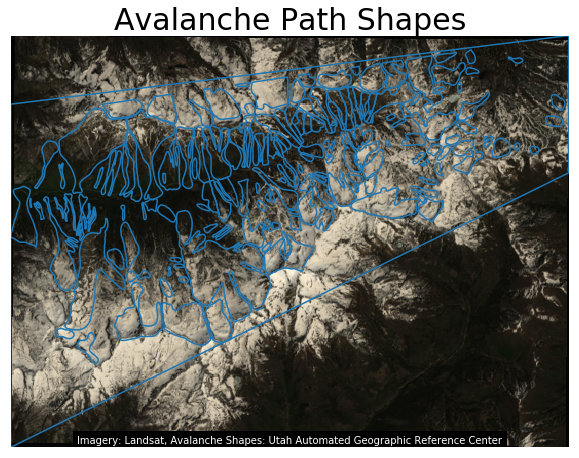

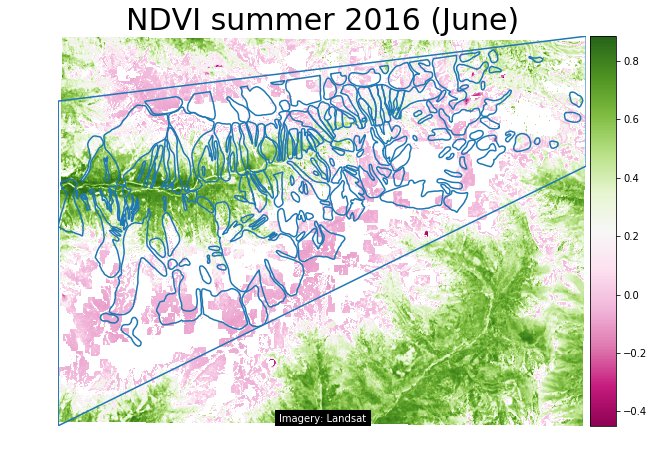

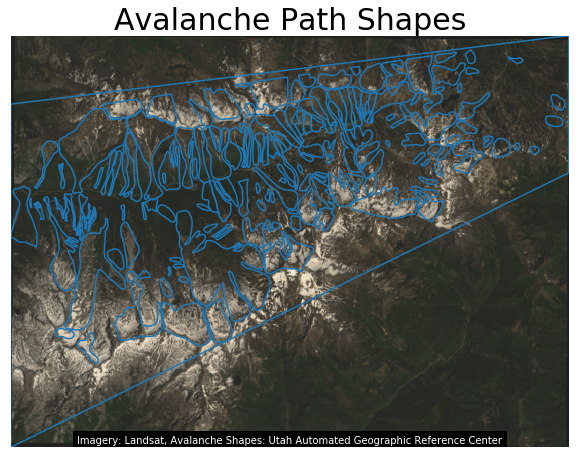

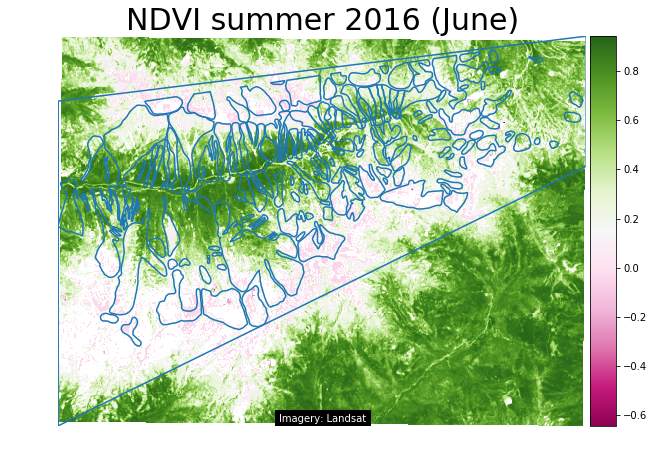

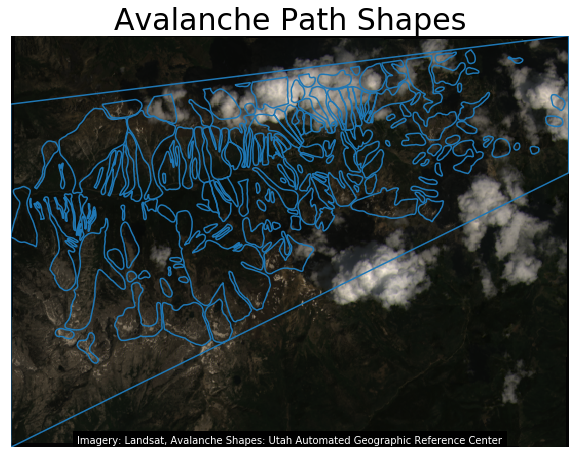

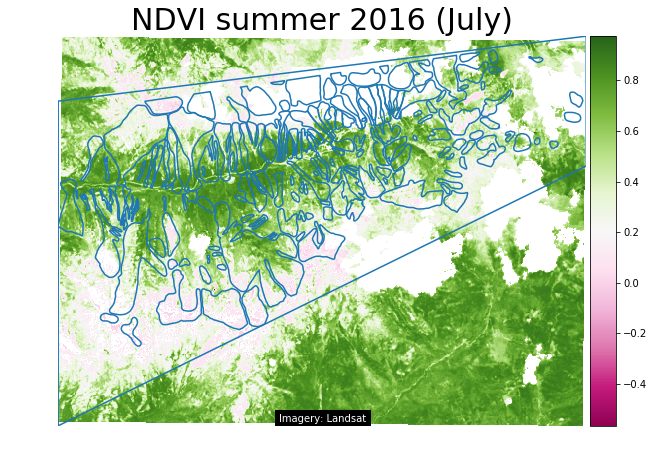

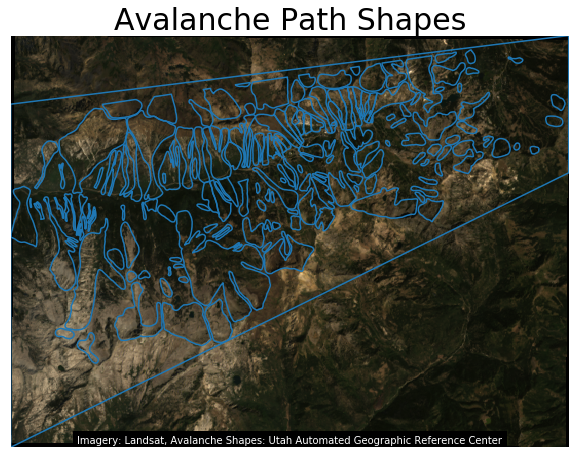

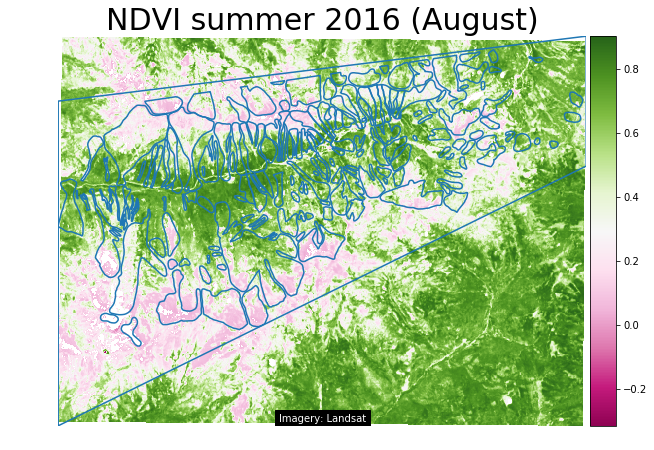

C:\Users\mdorf\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: All-NaN slice encountered
C:\Users\mdorf\Anaconda3\envs\earth-analytics-python\lib\site-packages\rasterstats\io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
C:\Users\mdorf\Anaconda3\envs\earth-analytics-python\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


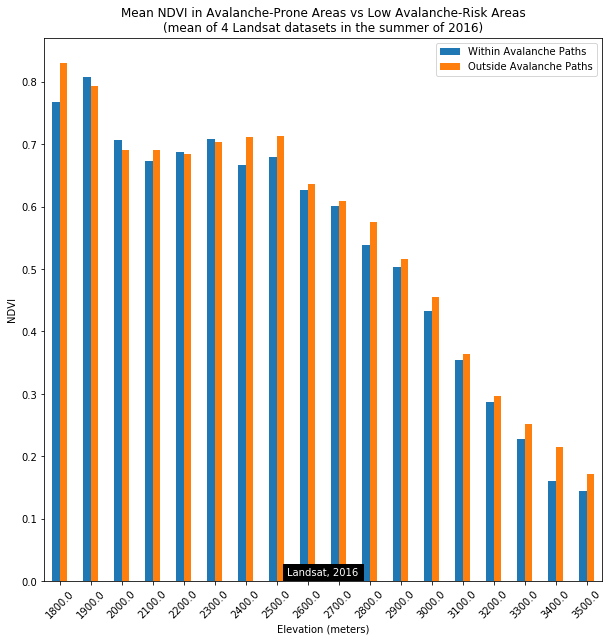

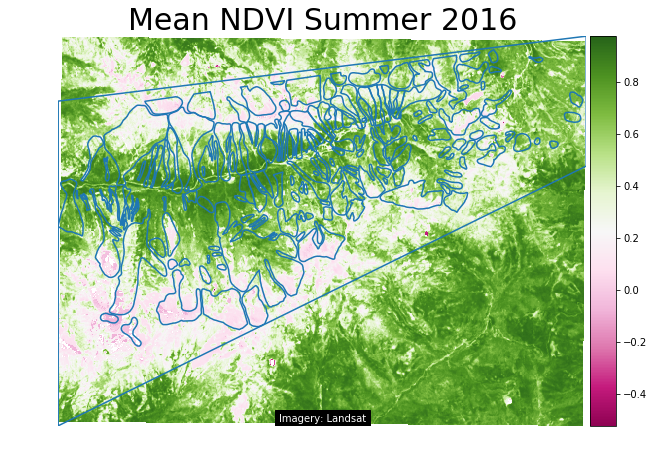

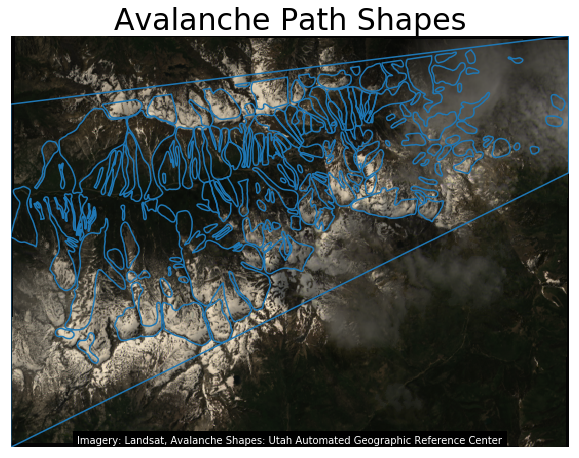

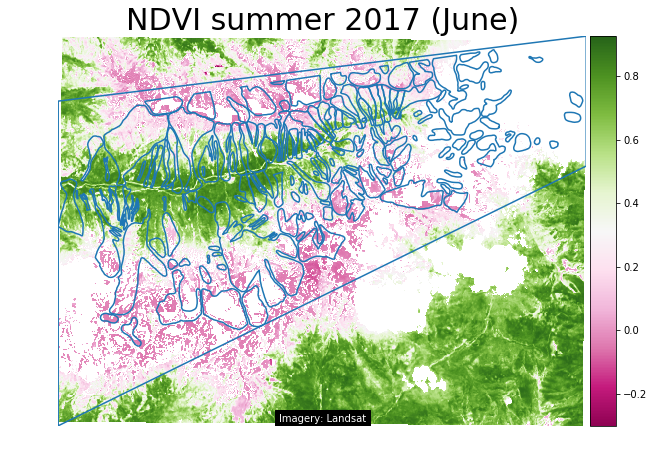

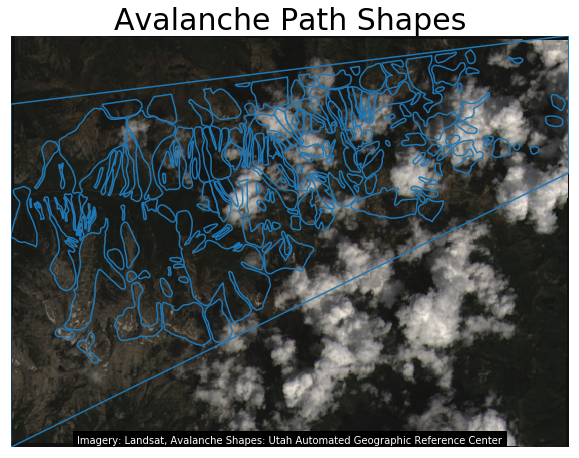

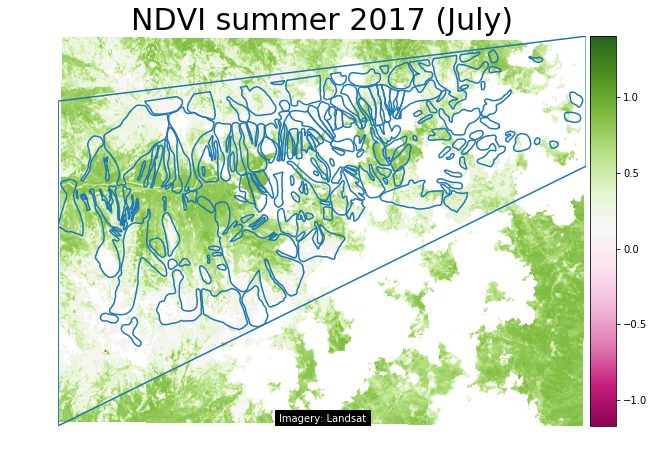

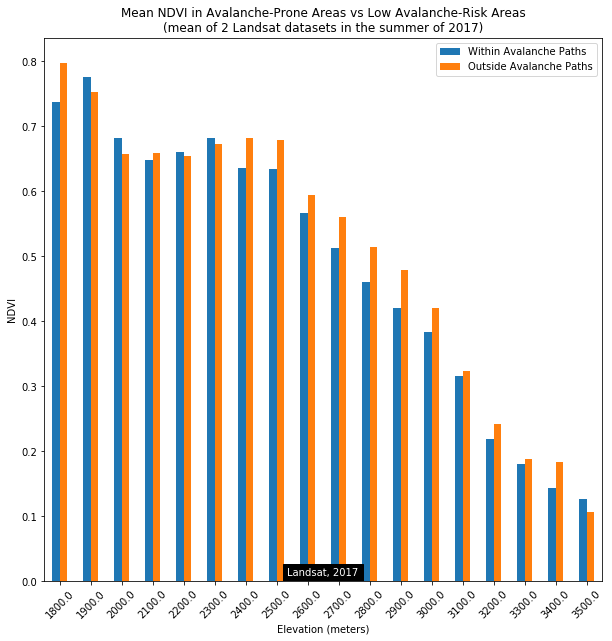

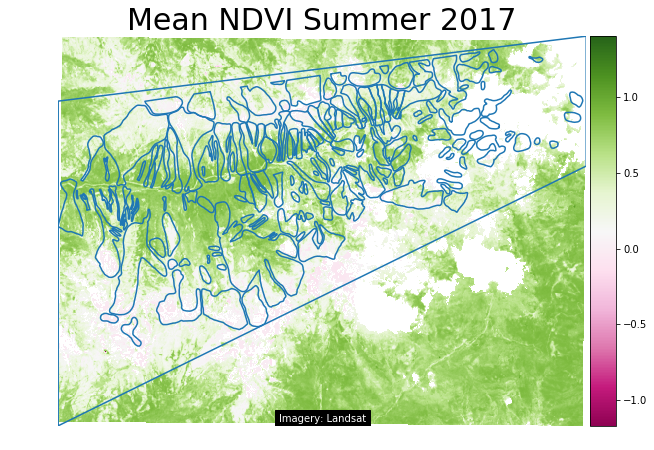

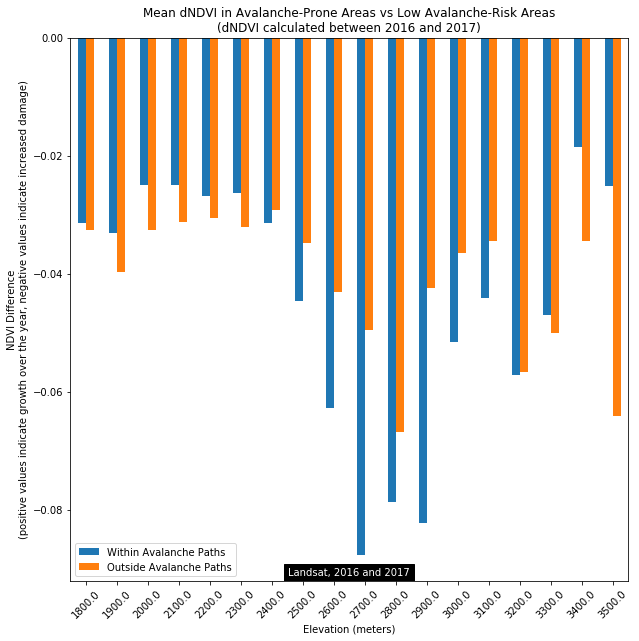

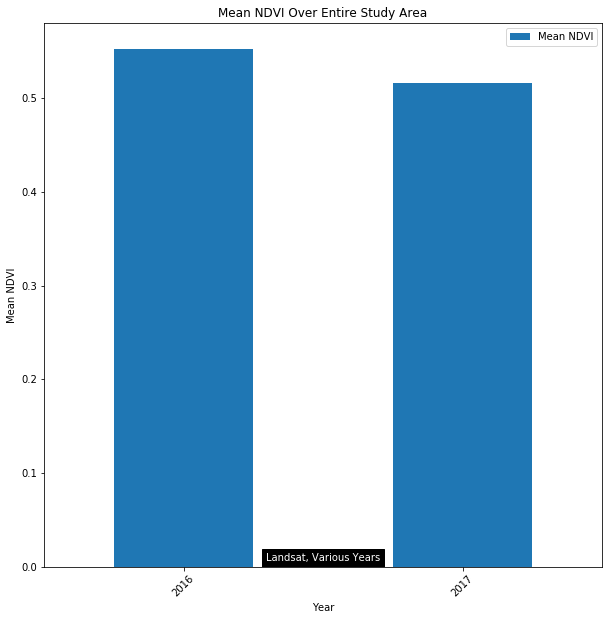

In [2]:
# This should match the qa layer
qa_match = 'pixel_qa'

# The order which we will be concatenating our tifs
color_order = ['red', 'green', 'blue', 'nir']

mean_ndvi_by_year = {}

# Crop all data
for landsat_name, years_present in landsat_inventory.items():
    if landsat_name == 'landsat_7':
        band_colors = {
            'blue': 'band1',
            'green': 'band2',
            'red': 'band3',
            'nir': 'band4'
        }
    elif landsat_name == 'landsat_8':
        # This is a dictionary which matches patterns for each of the filenames
        band_colors = {
            'blue': 'band2',
            'green': 'band3',
            'red': 'band4',
            'nir': 'band5'
        }
    else:
        raise ValueError("Unknown name %s" % landsat_name)
    for year, file_list in years_present.items():
        if not file_list:
            print("No files found for landsat type %s and year %s" % (landsat_name, year))
            continue
        accumulated_ndvi_arrays = []
        for file in file_list:
            accumulated_bands_list = []
            accumulated_bands_list_unmasked = []
            full_path = os.path.join(landsat_file_root, landsat_name, year, file)            
            
            # Get QA layer to create our cloud mask
            qa_file_name = files_from_pattern(os.path.join(full_path, "*%s*" % qa_match), 
                                                 expect_single_file=True)[0]
            with rio.open(qa_file_name) as src:
                # Reproject our shape to whatever projection the landsat data is in
                landsat_crs = src.crs
                landsat_res = src.res
                landsat_transform = src.transform
                study_area_box_reprojected = common.study_area_box_gdf.to_crs(landsat_crs)
                qa_arr, _ = mask.mask(src, study_area_box_reprojected.geometry, crop=True)
                qa_arr = np.squeeze(qa_arr)

                cloud_mask = mask_clouds(qa_arr, landsat_ver=landsat_name)

            if avalanche_overlap_shape is None:
                # This step takes forever when you run it for the first 
                # time and if the geojson isn't available on disk
                # Would prefer to do this once at the top, but we need
                # to know the crs of the landsat file we're loading
                avalanche_overlap_shape = common.generate_unioned_avalanche_overlay(landsat_crs)
                
            # Loop through the colors necessary to create NDVI
            for color in color_order:
                band_file_name = files_from_pattern(os.path.join(full_path, "*%s*" % band_colors[color]), 
                                                    expect_single_file=True)[0]
                with rio.open(band_file_name) as src:
                    # Reproject our shape to whatever projection the landsat data is in
                    masked_band, masked_band_affine = mask.mask(src, study_area_box_reprojected.geometry, crop=True)
                    masked_band = np.squeeze(masked_band)
                    
                    # Mask invalid values
                    masked_band[masked_band == -9999] = ma.masked
                    
                    # Save unmasked image
                    accumulated_bands_list_unmasked.append(masked_band.copy())
                    
                    # Mask clouds                    
                    masked_band[cloud_mask] = ma.masked                    
                    accumulated_bands_list.append(masked_band)          

            accumulated_bands_arr = np.array(accumulated_bands_list)
            accumulated_bands_arr_unmasked = np.array(accumulated_bands_list_unmasked)
            ndvi_arr = common.calculate_NDVI(accumulated_bands_arr)
            accumulated_ndvi_arrays.append(ndvi_arr)
          
            common.plot_array_and_vector(accumulated_bands_arr_unmasked, 
                                                   landsat_crs,
                                                   "Avalanche Path Shapes", 
                                                   "Imagery: Landsat, Avalanche Shapes: Utah Automated Geographic Reference Center")
            
            month_datetime = datetime.datetime.strptime(file[14:16], '%m')
            common.plot_array_and_vector(ndvi_arr, 
                                           landsat_crs,
                                           "NDVI summer %s (%s)" % (year, month_datetime.strftime('%B')), 
                                           "Imagery: Landsat")
            
        if accumulated_ndvi_arrays:
            accumulated_ndvi_arrays_stacked = np.array(accumulated_ndvi_arrays)
            
            # Use nanmax so we have additional protection against low-bias for areas of snow
            annual_mean_ndvi = np.nanmax(accumulated_ndvi_arrays_stacked, axis=0)
            month_datetime = datetime.datetime.strptime(file[14:16], '%m')
            mean_ndvi_by_year[year] = annual_mean_ndvi           
            
            merged_results_ndvi = common.rasterstats_grouped_by_height(avalanche_overlap_shape, 
                                                                       annual_mean_ndvi, 
                                                                       masked_band_affine, 
                                                                       "mean")            
            
            common.plot_bar(merged_results_ndvi[merged_results_ndvi['height_bucket'] != 0], 
                     "height_bucket", 
                     "Elevation (meters)", 
                     ['mean_avalanche', 'mean_no_avalanche'], 
                     "NDVI", 
                     "Mean NDVI in Avalanche-Prone Areas vs Low Avalanche-Risk Areas\n" + \
                     "(mean of %d Landsat datasets in the summer of %s)" % (len(accumulated_ndvi_arrays), year), 
                     "Landsat, %s" % year,
                      series_names=['Within Avalanche Paths', 
                                    'Outside Avalanche Paths'])
            
            common.plot_array_and_vector(annual_mean_ndvi, 
                                         landsat_crs,
                                         "Mean NDVI Summer %s" % (year), 
                                         "Imagery: Landsat",
                                         fname='NDVI %s' % year)
            
            # Plot the dNDVI if we have more than one years' worth of data
            if len(mean_ndvi_by_year) > 1:
                merged_results_dndvi = common.rasterstats_grouped_by_height(avalanche_overlap_shape, 
                                                                           annual_mean_ndvi - previous_ndvi, 
                                                                           masked_band_affine, 
                                                                           "mean")
                
                common.plot_bar(merged_results_dndvi[merged_results_dndvi['height_bucket'] != 0], 
                     "height_bucket", 
                     "Elevation (meters)", 
                     ['mean_avalanche', 'mean_no_avalanche'], 
                     "NDVI Difference\n(positive values indicate growth over the year, " + \
                     "negative values indicate increased damage)", 
                     "Mean dNDVI in Avalanche-Prone Areas vs Low Avalanche-Risk Areas\n" + \
                     "(dNDVI calculated between %s and %s)" % (previous_year, year), 
                     "Landsat, %s and %s" % (previous_year, year),
                      series_names=['Within Avalanche Paths', 
                                    'Outside Avalanche Paths'])

            previous_ndvi = annual_mean_ndvi
            previous_year = year
    
# Analyze the annual mean NDVI over our study period
mean_NDVI_over_entire_study_area = pd.DataFrame(
    data={
        "year": [year for year in mean_ndvi_by_year.keys()],
        "mean_ndvi_over_entire_study_area": [np.nanmean(array) for array in mean_ndvi_by_year.values()],
    })
common.plot_bar(mean_NDVI_over_entire_study_area, 
                 "year", 
                 "Year", 
                 ['mean_ndvi_over_entire_study_area'], 
                 "Mean NDVI", 
                 "Mean NDVI Over Entire Study Area", 
                 "Landsat, Various Years",
                  series_names=['Mean NDVI'])
    

In [3]:

test5 = common.rasterstats_grouped_by_height(avalanche_overlap_shape, 
                                             mean_ndvi_list[1], 
                                             masked_band_affine, 
                                             "mean")
print(test5)
import pandas as pd
statistic = "mean"
dndvi_in_avalanche_paths = rs.zonal_stats(avalanche_overlap_shape,
                                          mean_ndvi_list[1],
                                          affine=masked_band_affine,
                                          geojson_out=True,
                                          stats=statistic)

results = pd.concat([pd.DataFrame({"avalanche_id": [item["properties"]["avalanche_id"]], 
                                   "height_bucket": [item["properties"]["height_bucket"]], 
                                   statistic: [item["properties"][statistic]],
                                   "size": [item["properties"]["geometry_sq_meters"]]}, 
                     columns=["avalanche_id", "height_bucket", statistic, "size"]) 
           for item in dndvi_in_avalanche_paths],
          ignore_index=True)

results['avalanche_id'] = results['avalanche_id'].fillna(value=False)
results['avalanche_id'] = results['avalanche_id'] != False
results = results.rename({'avalanche_id': 'is_avalanche'}, axis='columns')

difference = []
height_bucket = []
results_avalanche = (results
                    .where(results["is_avalanche"])
                    .groupby(["height_bucket"])[statistic]
                    .mean())
                    
results_no_avalanche = (results
                    .where(~results["is_avalanche"])
                    .groupby(["height_bucket"])[statistic]
                    .mean())

merged_results = pd.merge(results_avalanche.to_frame(), 
                          results_no_avalanche.to_frame(),
                          how='inner', 
                          on='height_bucket',
                          suffixes=('_avalanche', '_no_avalanche'))

merged_results["difference"] = merged_results[statistic + "_avalanche"] - merged_results[statistic + "_no_avalanche"]
merged_results = merged_results.reset_index()

merged_results.plot(x="height_bucket", y="difference", kind="bar")
merged_results

NameError: name 'mean_ndvi_list' is not defined

In [ ]:
for index, row in common.height_polygon_gdf.iterrows():
    print(index)
    print(row)
common.height_polygon_gdf.plot()

# Make a dataframe that contains shapes of every 100 foot interval in our data within our study area polygon
height_polygon_gdf.plot()


#an intersection of the avalanche paths and  cropped by both the
height, mean_ndvi = common.get_height_bins(common.elevation_dem_path, 
                                                       annual_mean_ndvi, 
                                                       'mean', 
                                                       common.study_area_box_gdf)
            


inProj = Proj(common.SHAPE_CRS)
outProj = Proj(landsat_crs)

dndvi_transform = from_origin(*transform(inProj, outProj, common.MIN_X, common.MAX_Y), *landsat_res)

print(dndvi_transform)

print(landsat_transform)
'''
from rasterio.warp import calculate_default_transform, reproject, Resampling

dest = np.ones_like(dndvi)
# Open elevation raster
with rio.open(common.elevation_dem_path) as src:
    study_area_box_reprojected = common.study_area_box_gdf.to_crs(src.crs)
    incoming_transform = from_origin(*transform(Proj(src.crs), outProj, study_area_box_reprojected.bounds['minx'].values[0], study_area_box_reprojected.bounds['maxy'].values[0]), *src.res)
    print(study_area_box_reprojected.bounds['minx'].values[0])
    masked_band, out_transform = mask.mask(src, study_area_box_reprojected.geometry, crop=True)
    print(out_transform)
    masked_band_squeezed = np.squeeze(masked_band)
    
    reproject(
        source=masked_band_squeezed,
        destination=dest,
        src_transform=incoming_transform,
        src_crs=src.crs,
        dst_transform=landsat_transform,
        dst_crs=landsat_crs)
    print(np.nanmean(masked_band_squeezed))
    print(np.nanmean(dest))
    print(np.unique(dest))
    print(masked_band_squeezed.shape)
    print(dest.shape)
'''
# Save the numpy array to disk as a geotiff so we can perform rasterstats easily on it

# We don't need to keep this data (it can be recreated)
# so pop it into a temporary directory
dndvi_in_avalanche_paths = rs.zonal_stats(common.avalanche_shapes_path,
                                          dndvi,
                                          affine=dndvi_transform,
                                          geojson_out=True,
                                          stats="mean max")

# Filter by height
with rio.open(common.elevation_dem_path) as src:
    study_area_box_reprojected = common.study_area_box_gdf.to_crs(src.crs)
    masked_band, out_transform = mask.mask(src, study_area_box_reprojected.geometry, crop=True)    
    masked_band = np.squeeze(masked_band)
    
    # Make polygon that is defined by the values below a specified threshold (disabled for now)
    '''
    is_below_height_thresh = np.zeros_like(masked_band)
    height_threshold = 3000
    is_below_height_thresh[masked_band < height_threshold] = 1
    attribute_name = 'is_below_height_thresh'
    is_below_height_thresh_geometry = (
        {'properties': {attribute_name: v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            rasterio.features.shapes(is_below_height_thresh, transform=out_transform)))
    gpd_polygonized_raster = gpds.GeoDataFrame.from_features(list(is_below_height_thresh_geometry), crs=src.crs)    
    gpd_polygonized_raster_subset = gpd_polygonized_raster.loc[(gpd_polygonized_raster[attribute_name] == 1)]
    gpd_is_below_height_thresh = gpd_polygonized_raster_subset.dissolve(by=attribute_name)
    '''
    
    # Make polygon that is defined by heights that are in 100-meter intervals
    polygon_interval = 100
    height_buckets = (np.round(masked_band / polygon_interval) * polygon_interval).astype(np.int)
    attribute_name = 'height_bucket'
    height_buckets_geometry = (
        {'properties': {attribute_name: v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            rasterio.features.shapes(height_buckets, transform=out_transform)))
    # Dissolve so all our height buckets are one shape
    gpd_polygonized_raster = gpds.GeoDataFrame.from_features(list(height_buckets_geometry), crs=src.crs)
    gpd_polygonized_raster = gpd_polygonized_raster.loc[(gpd_polygonized_raster[attribute_name] != 0)]
    gpd_height_buckets = gpd_polygonized_raster.dissolve(by=attribute_name)
    dndvi_in_height_buckets = rs.zonal_stats(gpd_height_buckets,
                                             mean_ndvi_list[0],
                                             affine=out_transform,
                                             geojson_out=True,
                                             stats="mean max")
    
    height = []
    mean = []
    for height_bucket in dndvi_in_height_buckets:
        height.append(height_bucket['id'])
        mean.append(height_bucket['properties']['mean'])
    
    common.plot_bar(height, "Altitude (meters)",
                    mean, "NDVI",
                   "Mean Summertime NDVI vs Elevation",
                   "Landsat, 2016")


    #for index, row in gpd_height_buckets.iterrows():
    # Calculate mean NDVI and dNDVI in each bucket
    dndvi_in_avalanche_paths = rs.zonal_stats(common.avalanche_shapes_path,
                                              dndvi,
                                              affine=dndvi_transform,
                                              geojson_out=True,
                                              stats="mean max")
    #print(dndvi_in_height_buckets)
    #    print row['c1'], row['c2']
    #for shape, value in rasterio.features.shapes(masked_band, transform=out_transform):
    #    shape.plot()
    #    print(shape)
    #    print(value)
    #test = rasterio.features.shapes(is_over_height)
    #print(test)
    # Make a shape the inverse of the avalanche shape files that is the extent of the study area polygon
    study_area_avalanche_crs = common.study_area_gdf.to_crs(common.avalanche_shapes_object.crs)

    inverse_avalanche_shape = common.make_shapefile_inverse_within_box(study_area_avalanche_crs, 
                                                                       common.avalanche_shapes_object)    
    inverse_avalanche_shape = inverse_avalanche_shape.to_crs(src.crs)
    
    #dissolve(by="geometry")    
    #gpd_polygonized_raster.plot(column='height_meters')
    #rio.features.shapes()
    #polygons = [shapely.geometry.Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == 1]

    
     #with rasterio.open('a_raster') as src:
     #   image = src.read(1) # first band
     #   results = (
     #   {'properties': {'raster_val': v}, 'geometry': s}
     #   for i, (s, v) 
     #   in enumerate(
     #       shapes(image, mask=mask, transform=src.affine)))
    
    
    #print(out_transform)
    #masked_band_squeezed = np.squeeze(masked_band)
    
    #reproject(
     #   source=masked_band_squeezed,
      #  destination=dest,
       # src_transform=incoming_transform,
        #src_crs=src.crs,
    #    dst_transform=landsat_transform,
    #    dst_crs=landsat_crs)
    #print(np.nanmean(masked_band_squeezed))
    #print(np.nanmean(dest))
    #print(np.unique(dest))
    #print(masked_band_squeezed.shape)
    #print(dest.shape)

    
_ = common.plot_array_and_vector(dndvi, 
                                 landsat_crs,
                                 "Change in NDVI 2016-2017", 
                                 "Imagery: Landsat", 
                                 fname='dNDVI.jpg')


test = gpds.overlay(common.avalanche_shapes_object, gpd_is_below_height_thresh.to_crs(common.avalanche_shapes_object.crs), how='intersection')
#test = gpds.sjoin(common.avalanche_shapes_object.to_crs(crs=gpd_polygonized_raster_dissolved.crs), gpd_polygonized_raster_dissolved, how='inner', op='intersects', lsuffix='left', rsuffix='right')
test.plot()
common.avalanche_shapes_object.plot()
common.study_area_gdf.plot()
inverse_avalanche_shape.plot()